## Implementing a GAN in Keras

### Implementing Fully-Connected GAN (FCGAN)

In [0]:
# import modules
from keras.optimizers import Adam
import numpy as np

# Set random seed
np.random.seed(10)

# Set parameters
noise_dim = 100  # specifies the length of the random noise vector, z.
batch_size = 16
steps_per_epoch = 3750
epochs = 10
img_rows, img_cols, channels = 28, 28, 1

# Save path
save_path = 'fcgan_images'

# Initialize optimizer
optimizer = Adam(0.0002, 0.5)

In [0]:
# Import dataset and standardize/normalize the images
from keras.datasets import mnist
import os

In [3]:
# Load dataset. NOTE this is most important phase. Load the data type you'll want your generator to have access to.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalize train
X_train = (X_train.astype('float32') - 127.5) / 127.5
X_train = X_train.reshape(-1, img_rows*img_cols*channels)

# create directory
if not os.path.isdir(save_path):
  os.mkdir(save_path)

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# check dir
!ls

fcgan_images  sample_data


### Create Generator Network

In [0]:
# Import modules for Fully connected generator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

In [0]:
# Create generator network
def create_generator():
  generate = Sequential()
  generate.add(Dense(256, input_dim=noise_dim))
  generate.add(LeakyReLU(0.2))
  generate.add(Dense(512))
  generate.add(LeakyReLU(0.2))
  generate.add(Dense(1024))
  generate.add(LeakyReLU(0.2))
  generate.add(Dense(img_cols*img_rows*channels, activation='tanh')) # We must use the tanh activation for the final layer to stay consistent with our normalization of the images earlier, and for better results.

  # Compile generator
  generate.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generate


In [0]:
# Create discriminator network
def create_discriminator():
  discriminate = Sequential()
  discriminate.add(Dense(1024, input_dim=img_cols*img_rows*channels))
  discriminate.add(LeakyReLU(0.2))
  discriminate.add(Dense(512))
  discriminate.add(LeakyReLU(0.2))
  discriminate.add(Dense(256))
  discriminate.add(LeakyReLU(0.2))
  discriminate.add(Dense(1, activation='sigmoid'))

  # compile discriminator
  discriminate.compile(loss='binary_crossentropy', optimizer=optimizer)
  return discriminate

In [0]:
# Import modules for setting up GAN
from keras.layers import Input
from keras.models import Model

In [12]:
# Instantiate the discriminator and generator models
discriminator = create_discriminator()
generator = create_generator()

# set discriminator to trainable = False
discriminator.trainable = False

# Setup GAN for training
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)

# Compile the model
gan.compile(loss='binary_crossentropy', optimizer=optimizer)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
X_train.shape[0]

60000

In [16]:
# training loop for training the FCGAN
for epoch in range(epochs):
  for batch in range(steps_per_epoch):
    # Create fake data
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    fake_x = generator.predict(noise)

    # sample from real data
    real_x = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Concatenate real and fake
    x = np.concatenate((real_x, fake_x))

    # Create labels real and fake for the discriminator
    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size] = 0.9

    # train discriminator on batch and store loss
    d_loss = discriminator.train_on_batch(x, disc_y)

    # train the generator
    gen_y = np.ones(batch_size)
    g_loss = gan.train_on_batch(noise, gen_y)

  print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



Epoch: 0 	 Discriminator Loss: 0.5092576742172241 		 Generator Loss: 1.9831504821777344
Epoch: 1 	 Discriminator Loss: 0.5440092086791992 		 Generator Loss: 2.2126870155334473
Epoch: 2 	 Discriminator Loss: 0.5054048299789429 		 Generator Loss: 1.777773141860962
Epoch: 3 	 Discriminator Loss: 0.5282456874847412 		 Generator Loss: 1.4829604625701904
Epoch: 4 	 Discriminator Loss: 0.4831475615501404 		 Generator Loss: 1.6834895610809326
Epoch: 5 	 Discriminator Loss: 0.5574836134910583 		 Generator Loss: 1.404956340789795
Epoch: 6 	 Discriminator Loss: 0.5809389352798462 		 Generator Loss: 1.9778770208358765
Epoch: 7 	 Discriminator Loss: 0.4859837293624878 		 Generator Loss: 1.620767593383789
Epoch: 8 	 Discriminator Loss: 0.5014095306396484 		 Generator Loss: 1.606197714805603
Epoch: 9 	 Discriminator Loss: 0.5955297946929932 		 Generator Loss: 1.373908519744873


In [0]:
# View our results 
# Import modules
import matplotlib.pyplot as plt

# define plot function
def show_images(noise):
  generated_images = generator.predict(noise)
  plt.figure(figsize=(10, 10))

  for i, image in enumerate(generated_images):
    plt.subplot(10, 10, i+1)
    if channels == 1:
      plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
    else:
      plt.imshow(image.reshape((img_rows, img_cols, channels)))
    plt.axis('off')

  plt.tight_layout()
  plt.show()

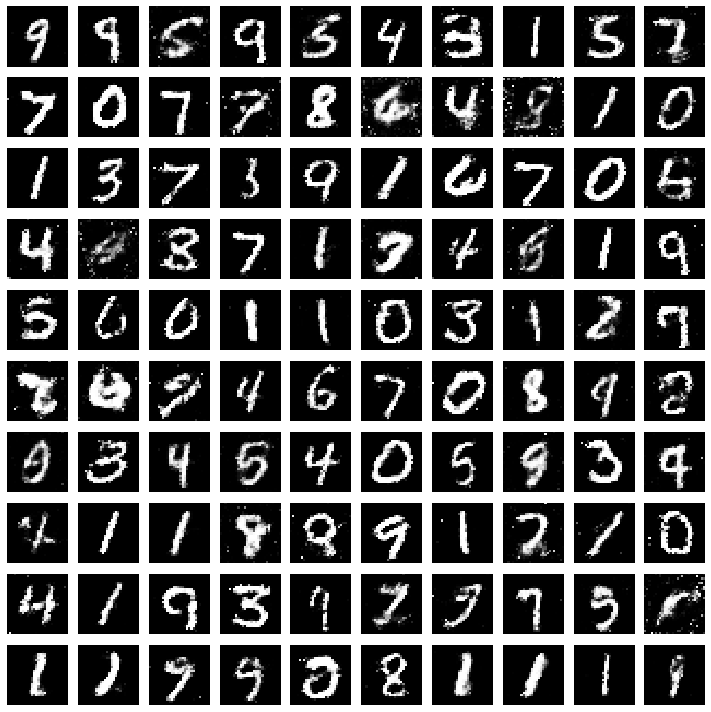

In [18]:
# Show images from noise
noise = np.random.normal(0, 1, size = (100, noise_dim))
show_images(noise)

### Implementing a Deep-Convolutional GAN (DCGAN)

In [1]:
# Import modules
from keras.datasets import cifar10
import numpy as np
import os
from keras.optimizers import Adam

# Set random seed
np.random.seed(10)

# Set parameters
noise_dim = 100  # specifies the length of the random noise vector, z.
batch_size = 16
steps_per_epoch = 3750
epochs = 10
img_rows, img_cols, channels = 32, 32, 3

# Save path
save_path = 'dcgan_images'

# Initialize optimizer
optimizer = Adam(0.0002, 0.5)

Using TensorFlow backend.


In [2]:
# Load dataset. NOTE this is most important phase. Load the data type you'll want your generator to have access to.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize train
X_train = (X_train.astype('float32') - 127.5) / 127.5
X_train = X_train.reshape((-1, img_rows, img_cols, channels))

# create directory
if not os.path.isdir(save_path):
  os.mkdir(save_path)

170500096/170498071 [==============================] - 4s 0us/step


In [9]:
X_train.shape

(5000, 32, 32, 3)

In [4]:
# Select only cats for computational reasons
X_train = X_train[np.where(y_train == 3)[0]]
X_train.shape

(5000, 32, 32, 3)

Create the DC Generator

In [0]:
# Import modules for Deep Convolutional generator
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal

In [0]:
# Create Generator model
def create_generator():
  generator = Sequential()

  # Starting size
  d = 4
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))
  # Reshape our deconv 4 x 4 x 256
  generator.add(Reshape((d, d, 256)))

  # 8 x 8 x 128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))

  # 16 x 16 x 128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))

  # 32 x 32 x 128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))

  # 32 x 32 x 3
  generator.add(Conv2D(channels, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), activation='tanh'))

  # compile model
  generator.compile(loss = 'binary_crossentropy', optimizer=optimizer)
  return generator

In [0]:
# Create Discriminator Model
def create_discriminator():
  discriminator = Sequential()

  discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))

  discriminator.compile(loss = 'binary_crossentropy', optimizer=optimizer)
  return discriminator

In [0]:
# Instantiate the discriminator and generator models
discriminator = create_discriminator()
generator = create_generator()

# set discriminator to trainable = False. This is the allow the discriminator not learn when we are training the generator. 
# By itself, it does not affect the discriminator
discriminator.trainable = False

# Setup GAN for training
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)

# Compile the model
gan.compile(loss='binary_crossentropy', optimizer=optimizer,)

In [0]:
# View our results 
# Import modules
import matplotlib.pyplot as plt

# define plot function
def show_images(noise, epoch= None):
  generated_images = generator.predict(noise)
  plt.figure(figsize=(10, 10))

  for i, image in enumerate(generated_images):
    plt.subplot(10, 10, i+1)
    if channels == 1:
      plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
    else:
      plt.imshow(image.reshape((img_rows, img_cols, channels)))
    plt.axis('off')

  plt.tight_layout()

  if epoch != None:
    plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
  plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

Epoch: 0 	 Discriminator Loss: 0.3825325667858124 		 Generator Loss: 2.4495699405670166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

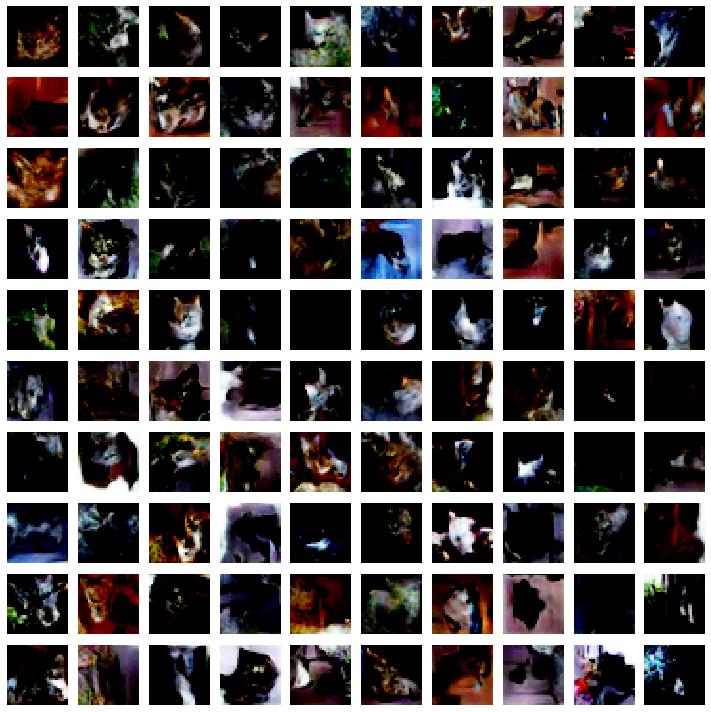

Epoch: 1 	 Discriminator Loss: 0.337863951921463 		 Generator Loss: 2.5787646770477295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 2 	 Discriminator Loss: 0.429720401763916 		 Generator Loss: 2.6688642501831055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

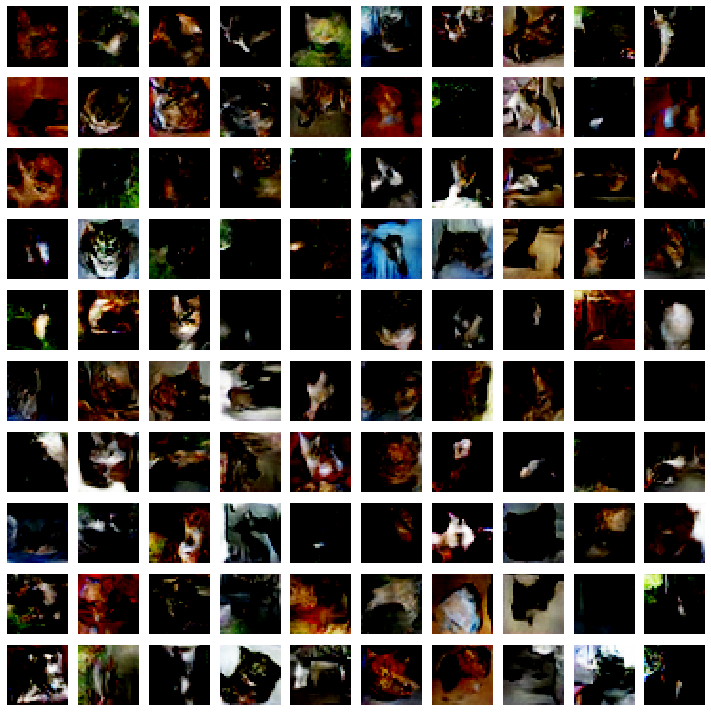

Epoch: 3 	 Discriminator Loss: 0.4804275631904602 		 Generator Loss: 2.710355043411255


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 4 	 Discriminator Loss: 0.41115039587020874 		 Generator Loss: 1.7676141262054443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

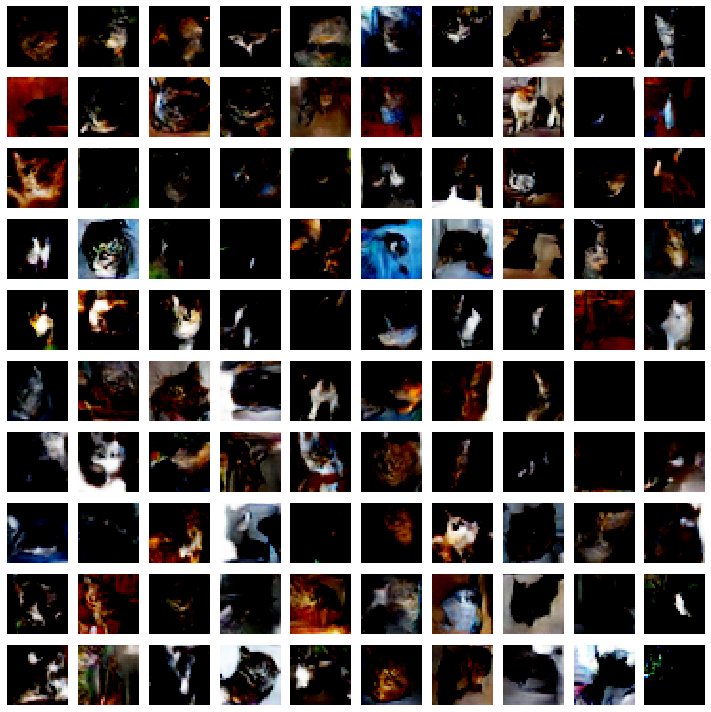

Epoch: 5 	 Discriminator Loss: 0.33378738164901733 		 Generator Loss: 2.8687877655029297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 6 	 Discriminator Loss: 0.3573416471481323 		 Generator Loss: 2.2491183280944824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

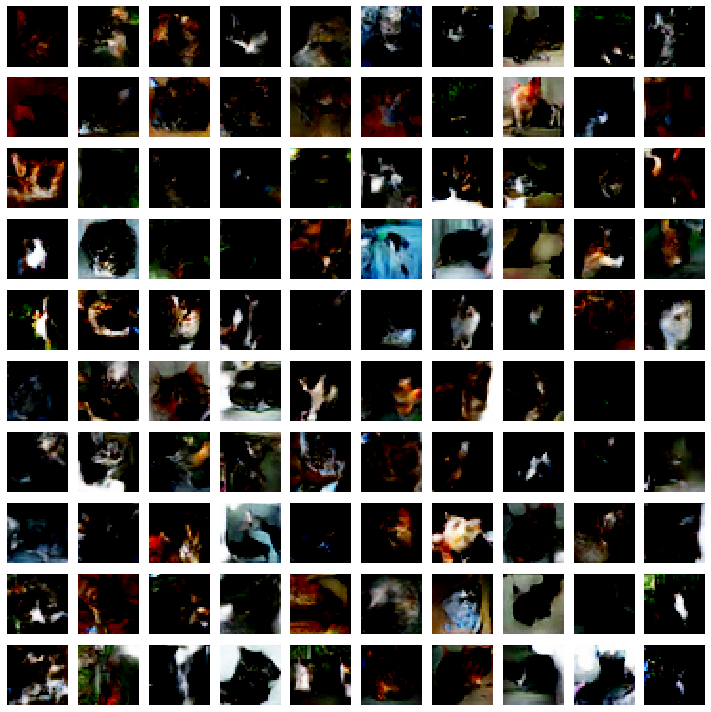

Epoch: 7 	 Discriminator Loss: 0.47131112217903137 		 Generator Loss: 3.1252927780151367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 8 	 Discriminator Loss: 0.4448859691619873 		 Generator Loss: 3.4127516746520996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

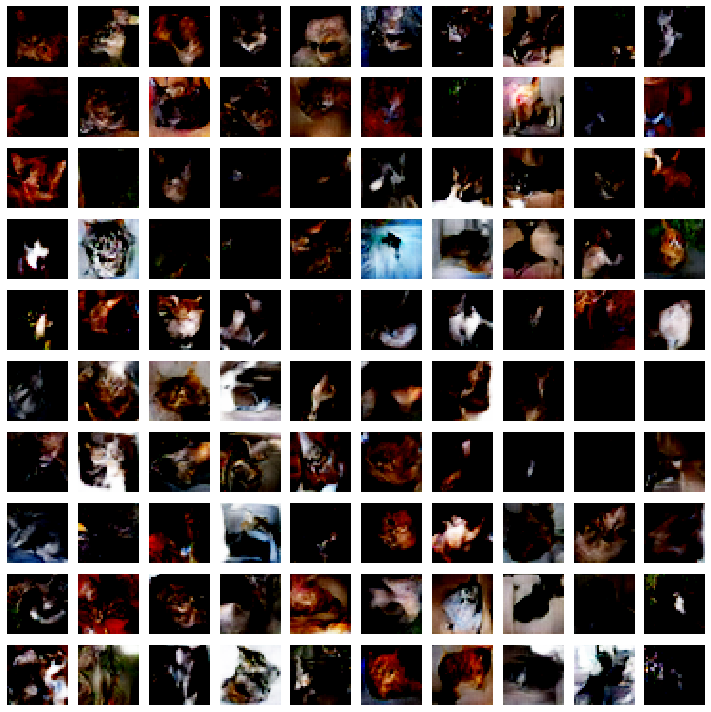

Epoch: 9 	 Discriminator Loss: 0.34529030323028564 		 Generator Loss: 2.832002639770508


In [32]:
# Create static_noise to test our generator
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

# training loop for training the FCGAN
for epoch in range(epochs):
  for batch in range(steps_per_epoch):
    # Create fake data
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    fake_x = generator.predict(noise)

    # sample from real data
    real_x = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

    # Concatenate real and fake
    x = np.concatenate((real_x, fake_x))

    # Create labels real and fake for the discriminator
    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size] = 0.9

    # train discriminator on batch and store loss
    d_loss = discriminator.train_on_batch(x, disc_y)

    # train the generator
    gen_y = np.ones(batch_size)
    g_loss = gan.train_on_batch(noise, gen_y)

  print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
  if epoch % 2 == 0:
    show_images(static_noise, epoch)

In [0]:
# Turn training process into a GIF. Save Images so we can create gifs from them.
from PIL import Image, ImageDraw
 
image_names = os.listdir(save_path)

frames = []
for image in sorted(image_names, key=lambda name:int(''.join(i for i in name if i.isdigit()))):
  frames.append(Image.open(save_path + '/' + image))

frames[0].save('gan_training2.gif', format='GIF', append_images=frames[1:], save_all = True, duration=80, loop=0)

discriminator.save('dcdiscriminator.h5')
generator.save('dcgenerator.h5')